In [1]:
import ipywidgets
# import pyvisa
# from pyvisa import ResourceManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import nidaqmx
from nidaqmx import system


## NI DAQ MX 

In [2]:
# Affichage des systèmes détectés
system = system.System.local()
print(system.driver_version)
for device in system.devices:
    print(device)

DriverVersion(major_version=23, minor_version=5, update_version=0)
Device(name=Dev1)


In [4]:
# # Access the collection of tasks stored in your System
# system = nidaqmx.system.system.System()
# system.tasks.task_name

### Acquisition 2

In [10]:

class TaskAcquisition:

    def __init__(self,sample_rate,number_of_samples,nb_of_reading,min_volt=-0.5,max_volt=0.5,channel="Dev1/ai0") -> None:
        # channel settings
        self.min_volt = min_volt
        self.max_volt = max_volt
        self.channel = channel

        # samples acquisition
        self.nb_of_reading = nb_of_reading
        self.sample_rate = sample_rate
        self.number_of_samples = number_of_samples

        self.nb_acquisition = 0
        self.acquired_samples = []

        #   task initialization
        self.task = nidaqmx.Task()
        self.task.ai_channels.add_ai_voltage_chan(self.channel, min_val=self.min_volt, max_val=self.max_volt)
        self.task.timing.cfg_samp_clk_timing(self.sample_rate,sample_mode=nidaqmx.constants.AcquisitionType.FINITE,samps_per_chan=int(self.number_of_samples*self.nb_of_reading))
        self.task.register_every_n_samples_acquired_into_buffer_event(self.number_of_samples, self.callback_function)
        self.task.register_done_event(self.callback_function_stop)


    def callback_function(self,task_handle, every_n_samples_event_type, number_of_samples, callback_data):
        self.acquired_samples += self.task.read(self.number_of_samples)
        self.nb_acquisition += 1


    def callback_function_stop(self,task_handle, status, callback_data):
        self.task.stop()

    def start_acquisition(self):
        self.task.start()

    def stop_acquisition(self):
        self.task.close()

    def plot_val(self):
        fig, ax = plt.subplots(figsize = (12,4))
        ax.plot(self.acquired_samples)





In [13]:
sample_rate = 5000 
nb_of_reading = 1
number_of_samples_per_read = 5000 * 60

Task = TaskAcquisition(sample_rate,number_of_samples_per_read,nb_of_reading)
Task.start_acquisition()

fin ini


Exception ignored on converting result of ctypes callback function: <bound method TaskAcquisition.callback_function of <__main__.TaskAcquisition object at 0x000001B85810B670>>
TypeError: 'NoneType' object cannot be interpreted as an integer
c:\Users\mtlsa\anaconda3\envs\conda_tx_2\lib\site-packages\ipykernel\iostream.py:153: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1b8580c15a0>
  self._event_pipes[threading.current_thread()] = event_pipe
Exception ignored on converting result of ctypes callback function: <bound method TaskAcquisition.callback_function_stop of <__main__.TaskAcquisition object at 0x000001B85810B670>>
TypeError: 'NoneType' object cannot be interpreted as an integer


callback


In [29]:
Task.stop_acquisition()


c:\Users\mtlsa\anaconda3\envs\conda_tx_2\lib\site-packages\nidaqmx\task.py:98: ResourceWarning: Task of name "_unnamedTask<4>" was not explicitly closed before it was destructed. Resources on the task device may still be reserved.
  warnings.warn(


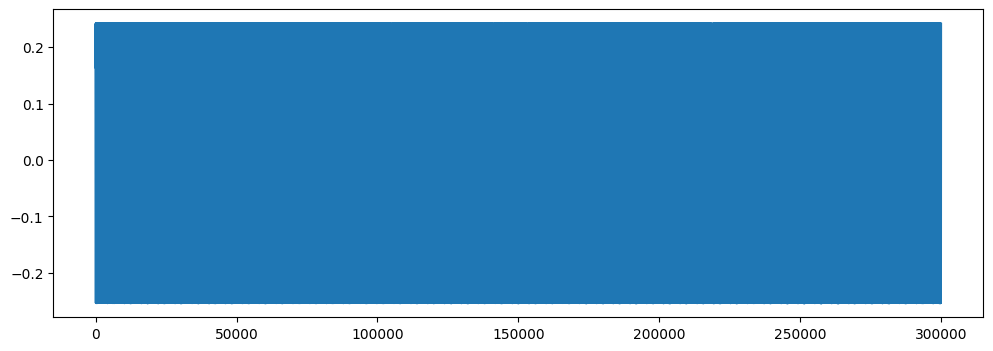

In [15]:
Task.plot_val()

In [14]:
len(Task.acquired_samples)

300000

### Acquisition

In [66]:
# Acquisition of signal

task = nidaqmx.Task()
physicalChannel = "Dev1/ai0"
minVoltage = -0.5
maxVoltage = 0.5

sampleRate = 5000 # frequence d'echantillonage
numberOfSamples = 1000 # nombre d'echantillon lu à la fois (plus le nombre d'échantillons à lire est faible plus la mise à jour (par exemple d'un affichage temps réelle) sera rapide)
task.ai_channels.add_ai_voltage_chan(physicalChannel, min_val=minVoltage, max_val=maxVoltage)
task.timing.cfg_samp_clk_timing(sampleRate,sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,samps_per_chan=numberOfSamples)


In [65]:
nb_acquisition_sec = 0.01 # durée d'acquisition en sec
sleep_time = 0.001  # période d'actualisation en sec, doit etre plus grand que frequence/numberOfsamples 
nb_acquisition_boucle = int(nb_acquisition_sec // sleep_time) + 1 # nombre total d'actualisation
all_val = [] # initialisation du tableau qui récupérera les données

def actualize(all_val):
    samplesAvailable = task._in_stream.avail_samp_per_chan
    if(samplesAvailable >= numberOfSamples):
        vals = task.read(numberOfSamples)
        print(vals)
        if len(vals) != 0:
            all_val += vals
        return all_val
    
    else:
        return all_val
try :
    task.start()
    
    for n in range(nb_acquisition_boucle):
        time.sleep(sleep_time)
        all_val = actualize(all_val)

except Exception as e:
    print(e)

finally:
    task.stop()
    task.close()



# Other syntax
# with nidaqmx.Task() as task:
#     ai_channel = task.ai_channels.add_ai_voltage_chan("Dev1/ao0", max_val=0.25, min_val=-0.25)

#     print(ai_channel.ai_max)
#     print(ai_channel.ai_min)


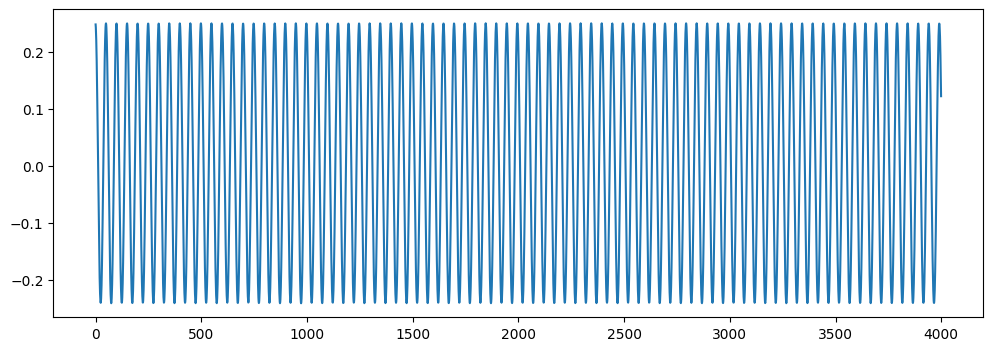

In [62]:
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(all_val)

In [23]:
assert len(all_val) == sampleRate*nb_acquisition_sec

### Génération

In [67]:
task = nidaqmx.Task()
physicalChannel = "Dev1/ao0"
minVoltage = -0.5
maxVoltage = 0.5

frequence = 100 # frequence du signal à générer
numberOfSamples = 1000 # nombre d'échantillon discretisant le signal sur une periode
sampleRate = frequence * numberOfSamples 
# frequence: nombre d'échantillon générer et transférer par seconde, d'ou le nombre de période sur une seconde est Fs/n 
# et chaque periode 1/f dure n/Fs ainsi Fs = f * n

duree = 5 # duree du signal genere en sec
amp = 0.25
t = np.arange(0,1,1/(sampleRate))
signal = list(amp*np.sin(2 * np.pi * frequence * t))*duree


task.ao_channels.add_ao_voltage_chan(physicalChannel, min_val=minVoltage, max_val=maxVoltage)
task.timing.cfg_samp_clk_timing(sampleRate,sample_mode=nidaqmx.constants.AcquisitionType.FINITE,samps_per_chan=len(signal))   

try :
    task.write(signal)
    task.start()
    time.sleep(duree)
    
    task.stop()
    task.close()
    complete = 1


except Exception as e:
    print(e)


finally:
    if complete == 0:
        task.stop()
        task.close()

propertyao_func_gen_freq
Specifies the frequency of the waveform to generate in hertz.

propertyao_func_gen_type
Specifies the kind of the waveform to generate.

Type
nidaqmx.constants.FuncGenType

https://nidaqmx-python.readthedocs.io/en/latest/ao_channel.html



 s the zero-to-peak amplitude of the waveform to generate in volts. Zero and negative values are valid.
ao_func_gen_freq  = #Specifies the frequency of the waveform to generate in hertz.
ao_func_gen_type = #Specifies the kind of the waveform to generate.
ao_min = #Specifies the minimum value you expect to generate

Site a voir
https://nspyre.readthedocs.io/en/latest/guides/ni-daqmx.html

with nidaqmx.Task() as task:
    task.ao_channels.add_ao_voltage_chan("Dev1/ao0")
    task.write([1.1, 2.2, 3.3, 4.4, 5.5], auto_start=True)

generation signal carree manuellement

## VISA connexion avec l'interface NI

In [15]:
rm = pyvisa.ResourceManager()
print(rm)
print(rm.list_resources()) 
# C:\windows\system32\visa32.dll  to visa64 ?

Resource Manager of Visa Library at C:\windows\system32\visa32.dll
()


The output is a tuple listing the VISA resource names. You can use a dedicated regular expression syntax to filter the instruments discovered by this method. The syntax is described in details in list_resources(). The default value is ‘?*::INSTR’ which means that by default only instrument whose resource name ends with ‘::INSTR’ are listed (in particular USB RAW resources and TCPIP SOCKET resources are not listed). To list all resources present, pass ‘?*’ to list_resources.
https://pyvisa.readthedocs.io/en/latest/introduction/communication.html


In [13]:
pyvisa.ResourceManager('@py')

<ResourceManager(<PyVisaLibrary('py')>)>

In [9]:
my_instrument = rm.open_resource('name in the list of resources')

VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

In [ ]:

# my_instrument.read_termination = '\n'
# my_instrument.write_termination = '\n'

my_instrument.query("*IDN?")

# same as 
# my_instrument.write('*IDN?')
# print(my_instrument.read())


# You can configure PyVISA to communicate to your instrument using a different baud rate as follows:

# my_instrument.baud_rate = 57600


## Affichage des données à partir des fichiers txt

In [2]:
with open('Signaux\Test TX 11-09\Absorption Coefficient (FeutreFaibleDensite, Small).txt') as file_sig:
    file_content = file_sig.readlines()

print(type(file_content),file_content)

<class 'list'> ['Header Size:\t 78\t \n', 'Pulse Version:\t 42\t \n', 'Decimal Symbol:\t,\t \n', 'Date Format:\tdd/MM/yyyy\t \n', 'Time Format:\tHH:mm:ss:mmm\t \n', 'Data Type:\tReal\t \n', 'Slice:\tFalse\t \n', 'Z-Axis type:\tLinear\t \n', 'Z-Axis size:\t1\t \n', 'Z-Axis unit:\t \t \n', 'Z-Axis first value:\t 0,0000000000e+000\t \n', 'Z-Axis delta:\t 1,0000000000e+000\t \n', 'X-Axis type:\tLinear\t \n', 'X-Axis size:\t6401\t \n', 'X-Axis unit:\tHz\t \n', 'X-Axis first value:\t 0,0000000000e+000\t \n', 'X-Axis delta:\t 1,0000000000e+000\t \n', '\t \t \n', 'AmplitudeUnit:\t \t \n', 'Analyzer:\tFFT_Spectrum_Averaging\t \n', 'AnalyzerName:\tFFT Analyzer\t \n', '\t \t \n', '\t \t \n', 'Bipolar:\tFalse\t \n', 'CenterFrequency:\t 3,2000000000e+003\t \n', '\t \t \n', '\t \t \n', '\t \t \n', '\t \t \n', 'dBReference:\t 1,0000000000e+000\t \n', '\t \t \n', '\t \t \n', '\t \t \n', 'Domain:\t1\t \n', 'Function:\tFrequency Response\t \n', '\t \t \n', '\t \t \n', '\t \t \n', '\t \t \n', 'MultiBuffe

In [3]:
def file_content_to_df(file_content):
    sig_line = [ line for line in file_content if line[0] in [str(x) for x in np.arange(0,10) ]]
    sig_items = [sig_line[i].split('\t') for i in range(len(sig_line))]
    if len(sig_items[0]) == 4 :
        list_col = ['0','id','col1','col2'] 
        last_col = 'col2'
    elif len(sig_items[0]) == 3 :
        list_col = ['0','id','col1']
        last_col = 'col1'

    df_sig = pd.DataFrame(sig_items, columns = list_col)
    df_sig[last_col] = df_sig[last_col].apply(lambda x: x[:-1])
    df_sig.head(3)


    for col in list_col[1:]:
        df_sig[col] = df_sig[col].apply(lambda x : x.replace(',','.'))
        df_sig[col] = df_sig[col].apply(lambda x : x.split('e'))
        df_sig[col] = df_sig[col].apply(lambda x : float(x[0]) * (10**float(x[1])))

    return df_sig

In [4]:
df_sig = file_content_to_df(file_content)

In [5]:
## Transfert Function
def Transfert_f(df_sig):
    fig,ax = plt.subplots(1,3,figsize = (10,5))
    ax[0].plot(np.clip(df_sig['col1'],a_min=0,a_max=None))
    ax[0].set_yscale('linear')

    ax[1].plot(np.clip(df_sig['col2'],a_min=0,a_max=None))
    ax[1].set_yscale('linear')

    ax[2].plot(np.sqrt(df_sig['col1']**2 + df_sig['col2']**2))
    # np.abs([complex(x,y) for x,y in list(zip(df_sig['col1'],df_sig['col2']))])
    ax[2].set_yscale('linear')

def coeff(df_sig):
    plt.close('all')
    fig,ax = plt.subplots(1,2,figsize = (10,5))
    ax[0].plot(20*np.log(df_sig['col1'])) # U col1 * qqc pour etre en Pa
    ax[1].plot(np.clip(df_sig['col1'],a_max=None,a_min=0))



c:\Users\mtlsa\anaconda3\envs\conda_tx_2\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\mtlsa\anaconda3\envs\conda_tx_2\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


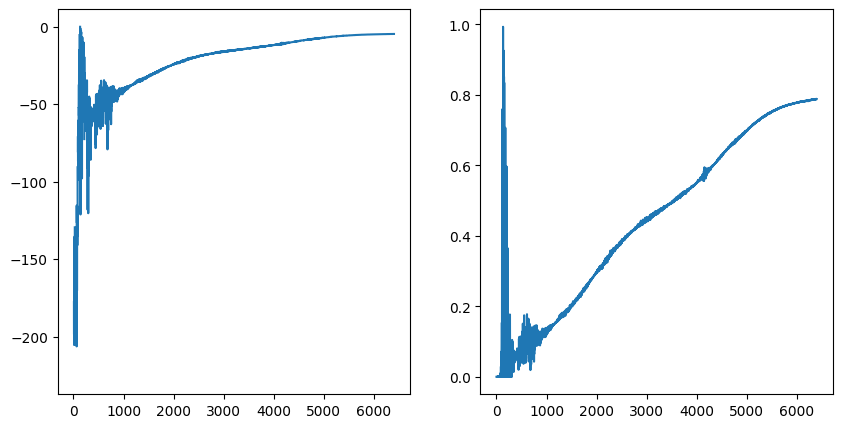

In [6]:
coeff(df_sig)

Correct, np.log(x) is the Natural Log (base e log) of x.

For other bases, remember this law of logs: log-b(x) = log-k(x) / log-k(b) where log-b is the log in some arbitrary base b, and log-k is the log in base k, e.g.

here k = e

l = np.log(x) / np.log(100)
and l is the log-base-100 of x